In [ ]:
import os
import cv2
import glob
import math
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import numpy as np
import pandas as pd
import os
from matplotlib import gridspec
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'data')
print(f'datasets directory: {dataset_dir}')

current directory: /Users/mahdiehmoghiseh/Desktop/sbu/project-s
datasets directory: /Users/mahdiehmoghiseh/Desktop/sbu/project-s/data


In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

norm_dir = './data/norm'
sch_dir = './data/sch'
n_channels = 16
n_times = 7680
chunk_size = 640

def chunk_data(X, y, chunk_size):
    """Chunks the data into non-overlapping segments of size chunk_size."""
    X_chunks = []
    y_chunks = []

    for i in range(X.shape[0]):
        for start in range(0, X.shape[2], chunk_size):
            end = start + chunk_size
            if end <= X.shape[2]:
                X_chunks.append(X[i, :, start:end])
                y_chunks.append(y[i])

    return np.array(X_chunks), np.array(y_chunks)

def load_eeg_data(directory, label):
    """Loads EEG data from files and assigns the given label."""
    eeg_data = []
    labels = []
    filenames = sorted([f for f in os.listdir(directory) if f.endswith('.eea')])

    for filename in filenames:
        file_path = os.path.join(directory, filename)
        data = np.loadtxt(file_path)
        data = data.reshape(n_times, n_channels).T
        eeg_data.append(data)
        labels.append(label)

    return np.array(eeg_data), np.array(labels)

norm_data, norm_labels = load_eeg_data(norm_dir, 0)
sch_data, sch_labels = load_eeg_data(sch_dir, 1)

factor = 4  # Number of times to duplicate label 1 data
sch_data_augmented = np.repeat(sch_data, factor, axis=0)
sch_labels_augmented = np.repeat(sch_labels, factor, axis=0)

factor1 = 4  # Number of times to duplicate label 1 data
norm_data_augmented = np.repeat(norm_data, factor1, axis=0)
norm_labels_augmented = np.repeat(norm_labels, factor1, axis=0)

X = np.concatenate((norm_data_augmented, sch_data_augmented), axis=0)
y = np.concatenate((norm_labels_augmented, sch_labels_augmented), axis=0)

shuffle_indices = np.random.permutation(X.shape[0])
X = X[shuffle_indices]
y = y[shuffle_indices]

X, y = chunk_data(X, y, chunk_size)

X_flattened = X.reshape(X.shape[0], -1)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_flattened, y)

X_balanced = X_balanced.reshape(-1, n_channels, chunk_size)

n_samples = X_balanced.shape[0]
n_per_class = np.min(np.bincount(y_balanced))
indices_0 = np.where(y_balanced == 0)[0][:n_per_class]
indices_1 = np.where(y_balanced == 1)[0][:n_per_class]
equal_indices = np.concatenate([indices_0, indices_1])
np.random.shuffle(equal_indices)

X_balanced = X_balanced[equal_indices]
y_balanced = y_balanced[equal_indices]

n_samples = X_balanced.shape[0]
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)

X_train_chunked, y_train = X_balanced[:train_size], y_balanced[:train_size]
X_val_chunked, y_val = X_balanced[train_size:train_size+val_size], y_balanced[train_size:train_size+val_size]
X_test_chunked, y_test = X_balanced[train_size+val_size:], y_balanced[train_size+val_size:]

print(X_train_chunked.shape)
print(X_val_chunked.shape)
print(X_test_chunked.shape)

(3456, 16, 640)
(432, 16, 640)
(432, 16, 640)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input

class SincNetLayer(layers.Layer):
    def __init__(self, num_filters, kernel_size, **kwargs):
        super(SincNetLayer, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.kernel = self.create_sinc_kernel()

    def sinc(self, x):
        return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sin(x) / x)

    def create_sinc_kernel(self):
        t = tf.linspace(-np.pi, np.pi, self.kernel_size)
        sinc_kernel = self.sinc(t)  # Shape: (kernel_size,)
        sinc_kernel = tf.reshape(sinc_kernel, (self.kernel_size, 1, 1))  # Shape: (kernel_size, 1, 1)
        return tf.tile(sinc_kernel, [1, 1, self.num_filters])  # Shape: (kernel_size, 1, num_filters)

    def call(self, inputs):
        input_channels = inputs.shape[-1]  # Get the number of input channels
        kernel = tf.tile(self.kernel, [1, input_channels, 1])  # Match input channels

        return tf.nn.conv1d(inputs, kernel, stride=1, padding='SAME')

    def compute_output_shape(self, input_shape):
        return input_shape

def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = SincNetLayer(num_filters=16, kernel_size=3)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('leaky_relu')(x)

    x = layers.Conv1D(256, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(256, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # Additional Dilated Convolution Layer for capturing more temporal features
    x = layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='leaky_relu')(x)
    x = layers.Dropout(0.35)(x)

    skip = x

    # One more dilated layer for long-range dependencies
    x = layers.Conv1D(128, kernel_size=3, dilation_rate=4, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='leaky_relu')(x)
    x = layers.Dropout(0.35)(x)

    # Adding pooling
    x = layers.Conv1D(128, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='leaky_relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Bottleneck
    encoded = layers.Conv1D(256, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='leaky_relu')(x)
    encoded = layers.Dropout(0.35)(encoded)

    # Decoder
    x = layers.Conv1DTranspose(128, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation='leaky_relu')(encoded)
    x = layers.UpSampling1D(size=2)(x)

    x = layers.Add()([x, skip])

    decoded = layers.Conv1DTranspose(16, kernel_size=3, activation='linear', padding='same')(x)

    autoencoder = models.Model(inputs, decoded)
    encoder = models.Model(inputs, encoded)  # Extract only the encoder part

    return autoencoder, encoder

input_shape = (640, 16)  # (chunk_size, n_channels)
autoencoder, encoder = create_autoencoder(input_shape)

def frequency_loss(y_true, y_pred):
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))

    return tf.reduce_mean(tf.square(tf.abs(fft_true) - tf.abs(fft_pred)))

def correlation_loss(y_true, y_pred):
    # Normalize the signals
    y_true_norm = y_true - tf.reduce_mean(y_true)
    y_pred_norm = y_pred - tf.reduce_mean(y_pred)

    corr_coeff = tf.reduce_sum(y_true_norm * y_pred_norm) / (tf.sqrt(tf.reduce_sum(y_true_norm**2)) * tf.sqrt(tf.reduce_sum(y_pred_norm**2)))

    return 1 - corr_coeff


def combined_loss(y_true, y_pred):
    # MSE loss
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    # Frequency loss
    freq_loss = frequency_loss(y_true, y_pred)
    cor_loss = correlation_loss(y_true, y_pred)

    return mse_loss + 0.5 * freq_loss + 0.5 * cor_loss

autoencoder.compile(optimizer='adam', loss=[combined_loss])

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 640, 16)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinc_net_layer      │ (None, 640, 16)   │          0 │ input_layer[0][0] │
│ (SincNetLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 640, 16)   │         64 │ sinc_net_layer[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 640, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 640, 256)  │     12,544 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 640, 256)  │      1,024 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 640, 256)  │    196,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 640, 256)  │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 640, 128)  │     98,432 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 640, 128)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 640, 128)  │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 640, 128)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 640, 128)  │     49,280 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 320, 128)  │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 320, 256)  │     98,560 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 320, 256)  │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 320, 128)  │     98,432 │ dropout_2[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 640, 128)  │          0 │ conv1d_transpose… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 640, 128)  │          0 │ up_sampling1d[0]… │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 640, 16)   │      6,160 │ add[0][0]       

 Total params: 611,664 (2.33 MB)

 Trainable params: 610,608 (2.33 MB)

 Non-trainable params: 1,056 (4.12 KB)

In [ ]:
X_train_chunked = np.transpose(X_train_chunked, (0, 2, 1))
X_val_chunked = np.transpose(X_val_chunked, (0, 2, 1))
X_test_chunked = np.transpose(X_test_chunked, (0, 2, 1))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = autoencoder.fit(X_train_chunked, X_train_chunked,
                          epochs=100,
                          batch_size=32,
                          validation_data=(X_val_chunked, X_val_chunked),
                          callbacks=[reduce_lr,EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
                         )

Epoch 1/100


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 538ms/step - loss: 9.6514 - val_loss: 6.2052 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 533ms/step - loss: 4.2693 - val_loss: 6.8347 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - loss: 3.6670 - val_loss: 6.2495 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - loss: 3.8609 - val_loss: 5.9864 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - loss: 3.4607 - val_loss: 5.9975 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 515ms/step - loss: 3.4725 - val_loss: 5.6095 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 567ms/step - loss: 3.3320 - val_loss: 5.5740 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - loss: 3.3181 - val_loss: 4.7462 - learning_rate: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 482ms/step - loss: 3.3117 - val_loss: 5.0846 - learning_rate: 0.0010
Epoc

In [ ]:
autoencoder.save('autoencoder_model2.h5')
encoder.save('encoder_model2.h5')

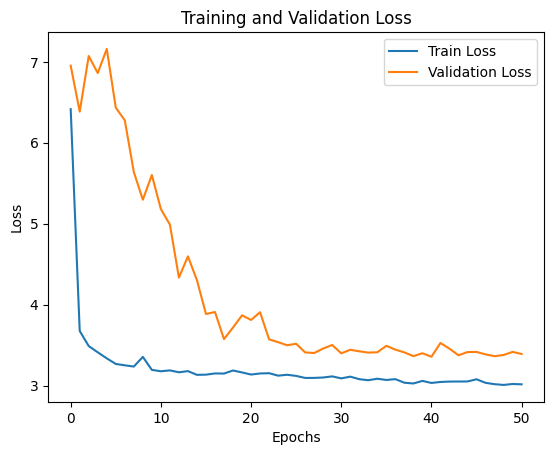

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on test data
test_loss = autoencoder.evaluate(X_test_chunked, X_test_chunked)
print(f'Test loss: {test_loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.6185
Test loss: 2.894355297088623


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


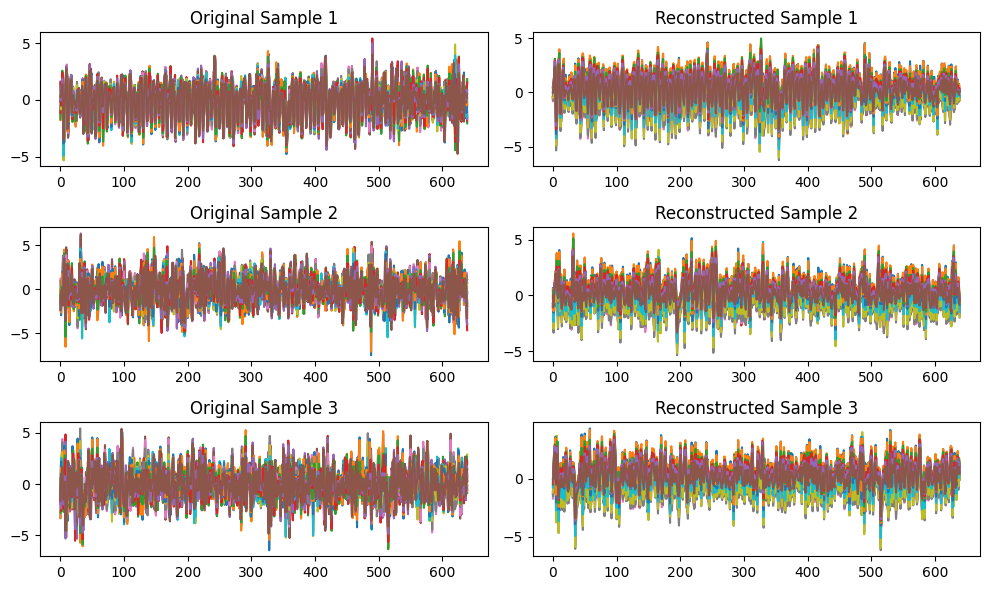

In [ ]:
reconstructed_samples = autoencoder.predict(X_test_chunked[:3])

def plot_reconstructions(original, reconstructed, num_samples=3):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        # Plot original samples
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.plot(original[i])
        plt.title(f'Original Sample {i+1}')

        # Plot reconstructed samples
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.plot(reconstructed[i])
        plt.title(f'Reconstructed Sample {i+1}')

    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test_chunked[:3], reconstructed_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


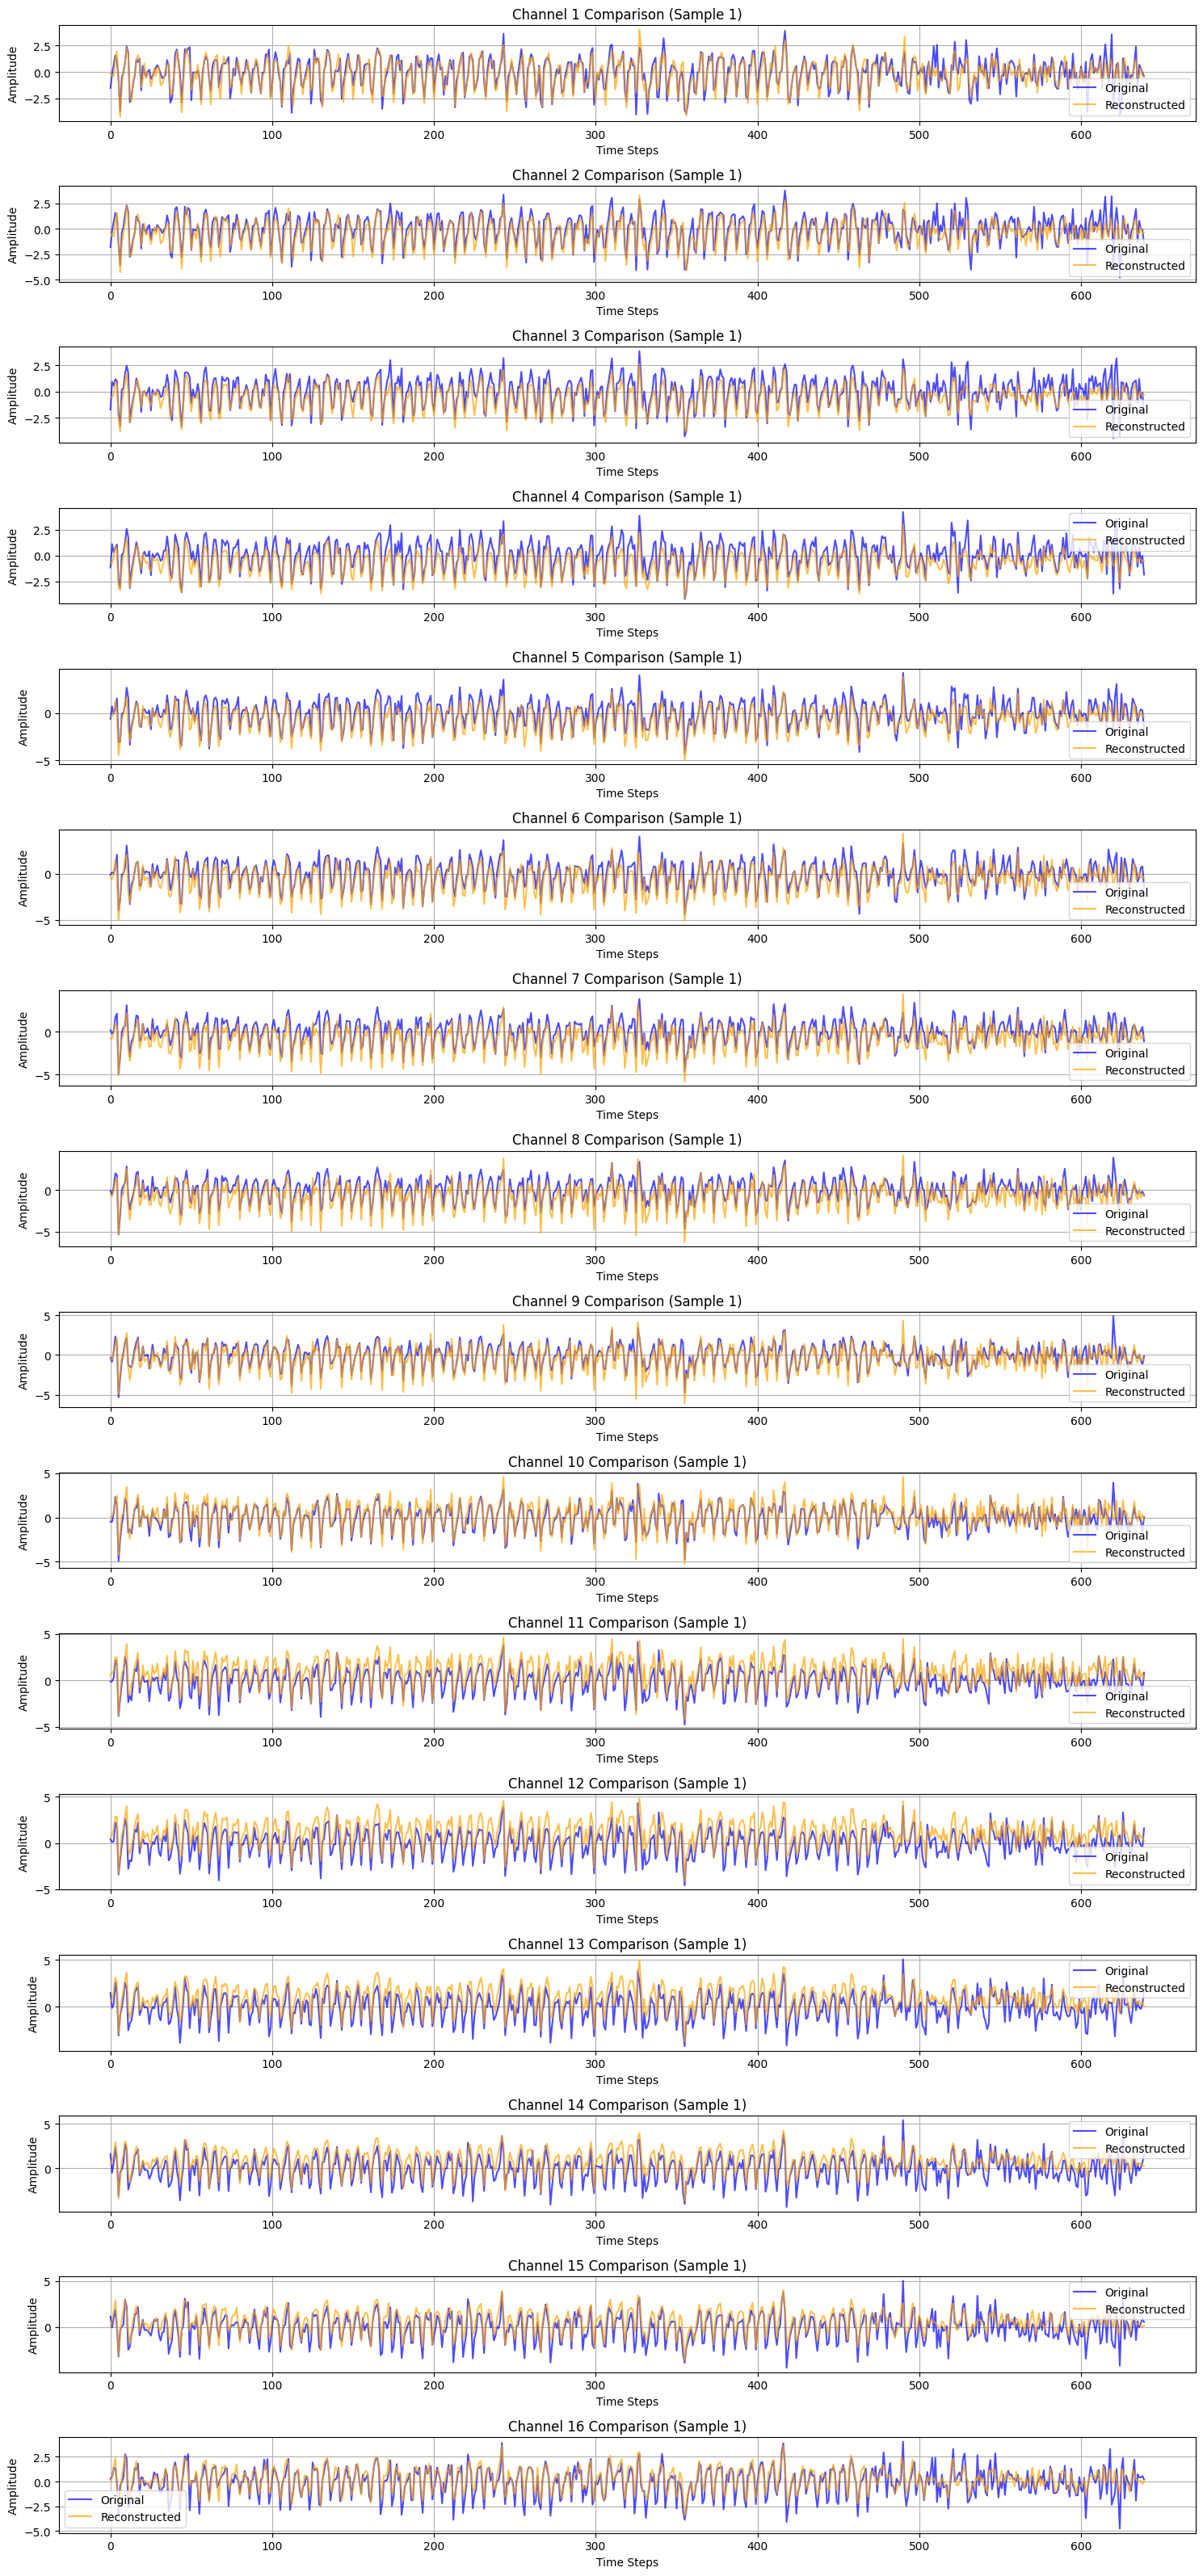

In [ ]:
import matplotlib.pyplot as plt

def plot_channel_reconstructions(original, reconstructed, sample_index=0):
    num_channels = original.shape[2]  # Get number of channels
    plt.figure(figsize=(15, 2 * num_channels))

    for channel in range(num_channels):
        # Create a new subplot for each channel
        plt.subplot(num_channels, 1, channel + 1)

        # Plot original channel
        plt.plot(original[sample_index, :, channel], label='Original', color='blue', alpha=0.7)

        # Plot reconstructed channel
        plt.plot(reconstructed[sample_index, :, channel], label='Reconstructed', color='orange', alpha=0.7)

        # Add title and labels
        plt.title(f'Channel {channel + 1} Comparison (Sample {sample_index + 1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot channel reconstructions for the first sample
reconstructed_samples1 = autoencoder.predict(X_test_chunked[:1])
plot_channel_reconstructions(X_test_chunked, reconstructed_samples1, sample_index=0)

In [ ]:
from tensorflow.keras.models import load_model

autoencoder_loaded = load_model('autoencoder_model.h5', custom_objects={
    'SincNetLayer': SincNetLayer,
    'combined_loss': combined_loss,
    'frequency_loss': frequency_loss,
    'correlation_loss': correlation_loss
})

encoder_loaded = load_model('encoder_model.h5', custom_objects={
    'SincNetLayer': SincNetLayer
})

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

norm_dir = './data/norm'
sch_dir = './data/sch'
n_channels = 16
n_times = 7680
chunk_size = 640

def chunk_data(X, y, chunk_size):
    """Chunks the data into non-overlapping segments of size chunk_size."""
    X_chunks = []
    y_chunks = []

    for i in range(X.shape[0]):
        for start in range(0, X.shape[2], chunk_size):
            end = start + chunk_size
            if end <= X.shape[2]:
                X_chunks.append(X[i, :, start:end])
                y_chunks.append(y[i])

    return np.array(X_chunks), np.array(y_chunks)

def load_eeg_data(directory, label):
    """Loads EEG data from files and assigns the given label."""
    eeg_data = []
    labels = []
    filenames = sorted([f for f in os.listdir(directory) if f.endswith('.eea')])

    for filename in filenames:
        file_path = os.path.join(directory, filename)
        data = np.loadtxt(file_path)
        data = data.reshape(n_times, n_channels).T
        eeg_data.append(data)
        labels.append(label)

    return np.array(eeg_data), np.array(labels)

norm_data, norm_labels = load_eeg_data(norm_dir, 0)
sch_data, sch_labels = load_eeg_data(sch_dir, 1)

factor = 4  # Number of times to duplicate label 1 data
sch_data_augmented = np.repeat(sch_data, factor, axis=0)
sch_labels_augmented = np.repeat(sch_labels, factor, axis=0)

factor1 = 4  # Number of times to duplicate label 1 data
norm_data_augmented = np.repeat(norm_data, factor1, axis=0)
norm_labels_augmented = np.repeat(norm_labels, factor1, axis=0)

X = np.concatenate((norm_data_augmented, sch_data_augmented), axis=0)
y = np.concatenate((norm_labels_augmented, sch_labels_augmented), axis=0)

shuffle_indices = np.random.permutation(X.shape[0])
X = X[shuffle_indices]
y = y[shuffle_indices]

X, y = chunk_data(X, y, chunk_size)

X_flattened = X.reshape(X.shape[0], -1)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_flattened, y)

X_balanced = X_balanced.reshape(-1, n_channels, chunk_size)

n_samples = X_balanced.shape[0]
n_per_class = np.min(np.bincount(y_balanced))
indices_0 = np.where(y_balanced == 0)[0][:n_per_class]
indices_1 = np.where(y_balanced == 1)[0][:n_per_class]
equal_indices = np.concatenate([indices_0, indices_1])
np.random.shuffle(equal_indices)

X_balanced = X_balanced[equal_indices]
y_balanced = y_balanced[equal_indices]

n_samples = X_balanced.shape[0]
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)

X_train_chunked, y_train = X_balanced[:train_size], y_balanced[:train_size]
X_val_chunked, y_val = X_balanced[train_size:train_size+val_size], y_balanced[train_size:train_size+val_size]
X_test_chunked, y_test = X_balanced[train_size+val_size:], y_balanced[train_size+val_size:]

print(X_train_chunked.shape)
print(X_val_chunked.shape)
print(X_test_chunked.shape)

(3456, 16, 640)
(432, 16, 640)
(432, 16, 640)


In [ ]:
X_train_chunked = np.transpose(X_train_chunked, (0, 2, 1))
X_val_chunked = np.transpose(X_val_chunked, (0, 2, 1))
X_test_chunked = np.transpose(X_test_chunked, (0, 2, 1))
print(X_train_chunked.shape)

encoded_train = encoder_loaded.predict(X_train_chunked)
encoded_val = encoder_loaded.predict(X_val_chunked)
encoded_test = encoder_loaded.predict(X_test_chunked)

print(encoded_train.shape)
X_train_reshaped = encoded_train.reshape(encoded_train.shape[0], -1)
X_val_reshaped = encoded_val.reshape(encoded_val.shape[0], -1)
X_test_reshaped = encoded_test.reshape(encoded_test.shape[0], -1)

scaler = StandardScaler()
# X_train_reshaped = encoded_train.reshape(-1, n_channels * chunk_size)
# X_val_reshaped = encoded_val.reshape(-1, n_channels * chunk_size)
# X_test_reshaped = encoded_test.reshape(-1, n_channels * chunk_size)

print(X_train_reshaped.shape)

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

print(X_train_scaled.shape)

# PCA for Dimensionality Reduction
# pca = PCA()
# pca.fit(X_train_scaled)

# # Plot Explained Variance
# explained_variance = np.cumsum(pca.explained_variance_ratio_)
# plt.plot(explained_variance)
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('PCA Explained Variance')
# plt.show()

(3456, 640, 16)
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
(3456, 320, 256)
(3456, 81920)
(3456, 81920)


(3456, 5)


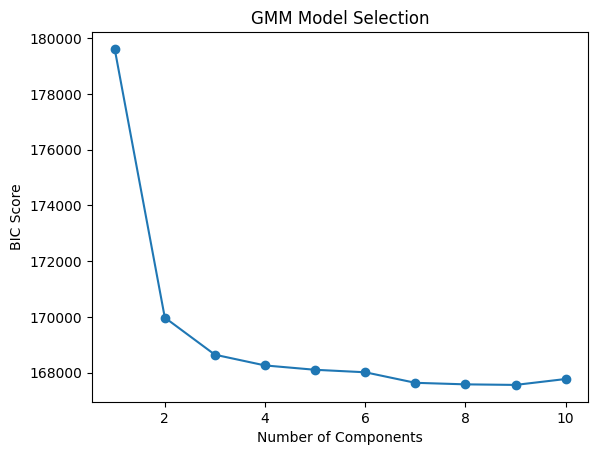

Optimal Number of GMM Components: 9


GaussianMixture(n_components=9, random_state=42)

In [ ]:
# n_components = np.argmax(explained_variance >= 0.95) + 1
# print(n_components)
pca = PCA(n_components=5)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_val_reduced = pca.transform(X_val_scaled)
X_test_reduced = pca.transform(X_test_scaled)

print(X_train_reduced.shape)

bic_scores = []
for num_components in range(1, 11):
    gmm = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
    gmm.fit(X_train_reduced)
    bic_scores.append(gmm.bic(X_train_reduced))

plt.plot(range(1, 11), bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('GMM Model Selection')
plt.show()

optimal_components = np.argmin(bic_scores) + 1
print(f'Optimal Number of GMM Components: {optimal_components}')

# optimal_components=2
gmm = GaussianMixture(n_components=optimal_components, covariance_type='full', random_state=42)
gmm.fit(X_train_reduced)

GMM Features Shape (Train): (3456, 9)
Train Accuracy: 0.9985532407407407
Validation Accuracy: 0.9907407407407407
Test Accuracy: 0.9884259259259259

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       219
           1       0.99      0.99      0.99       213

    accuracy                           0.99       432
   macro avg       0.99      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432



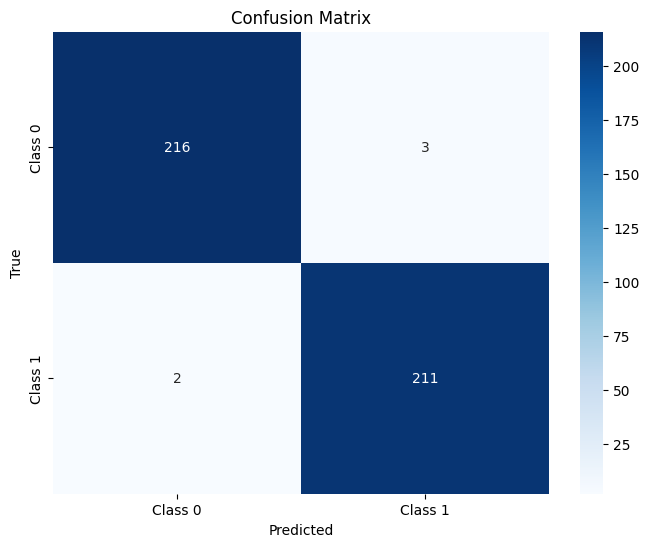

In [ ]:
from sklearn.ensemble import RandomForestClassifier

gmm_train_features = gmm.predict_proba(X_train_reduced)
gmm_val_features = gmm.predict_proba(X_val_reduced)
gmm_test_features = gmm.predict_proba(X_test_reduced)

print("GMM Features Shape (Train):", gmm_train_features.shape)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(gmm_train_features, y_train)

train_predictions = rf_classifier.predict(gmm_train_features)
val_predictions = rf_classifier.predict(gmm_val_features)
test_predictions = rf_classifier.predict(gmm_test_features)

print("Train Accuracy:", accuracy_score(y_train, train_predictions))
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print("Test Accuracy:", accuracy_score(y_test, test_predictions))

print("\nTest Classification Report:")
print(classification_report(y_test, test_predictions))

conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()